# Dog Breed Image Classification using AWS SageMaker


- In this project we will use pytorch pretrained model Resnet50 to classify different dog breeds.
- We will use the dataset openly available at https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
- We will also use hyperparameter tuning and extract the best hyperparameters for the model. 
- in the end we also make use to aws debugger and profilor to track the model training
- endpoint will be deployed and will be used to predictions. 


In [4]:
# install sagemaker debug package
#!pip install smdebug

Import important packages

In [6]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[2024-07-22 09:32:48.268 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:17 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


'sagemaker-us-east-1-283573335284'

## Dataset
The dataset consist of different dog breed images (133 difference breeds) and already grouped in test, train and validation datasets. 


Download the dataset from udacity bucket

In [7]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

--2024-07-22 09:33:05--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.64, 52.219.121.56, 52.219.194.136, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  33.8MB/s    in 42s     

2024-07-22 09:33:50 (25.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [4]:
# upload data to S3 bucket
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='imagesDogClassesSet')
print(f'Input path (S3 file path): {inputs}')

## Hyperparameter Tuning
We will be using Adam optimizer, and we will tune three key hyperparameters: learning rate, batch size, and epochs. For implicity we have use few option for example we will run only for 2 and 6 epochs. it will save our computational cost but still serves our ultimate purpose i.e, to demonstrate hyperparameter tuning and choosing the best model out of it.  

**Note:** We use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [ ]:
Here we are now creating an Pytorch estimator with entry point and other options. 

In [6]:
estimator = PyTorch(entry_point = 'hpo.py',
                    base_job_name = 'dog-breed-classification-hpo',
                    role = role,
                    instance_count = 1,
                    instance_type = 'ml.m5.2xlarge', 
                    py_version = 'py36',
                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs = 4,
                            max_parallel_jobs = 1,
                            objective_type = objective_type)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
tuner.fit({'train': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.......................................................................................................................................................................................!


In [8]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2024-03-04 19:30:03 Starting - Found matching resource for reuse
2024-03-04 19:30:03 Downloading - Downloading the training image
2024-03-04 19:30:03 Training - Training image download completed. Training in progress.
2024-03-04 19:30:03 Uploading - Uploading generated training model
2024-03-04 19:30:03 Completed - Resource reused by training job: pytorch-training-240304-1920-003-8d00f41c


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '4',
 'lr': '0.0017998026943613133',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-03-04-19-20-46-461"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-283573335284/dog-breed-classification-hpo-2024-03-04-19-20-46-461/source/sourcedir.tar.gz"'}

In [10]:
best_hyperparameters = {'batch_size': 32,
                        'epochs': 4,
                        'lr': 0.001799802694361313}

## Model Profiling and Debugging
Once we have identified the best hyperparameters for our image classification model, we will create a model and fine-tune it to improve its accuracy. By leveraging transfer learning and adjusting the last fully connected layer and adding our own layers, we will adapt the pre-trained model to our specific use case. By fine-tuning the model with the best hyperparameters, we aim to achieve optimal performance and accuracy for our dog breed classification task.

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

#collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
#                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
#                                                            "train.save_interval": "10",
#                                                            "eval.save_interval": "1"})]

#debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [42]:
from sagemaker.debugger import Rule, CollectionConfig, rule_configs
class_imbalance_rule = Rule.sagemaker(base_config=rule_configs.class_imbalance(),
                                    rule_parameters={"labels_regex": "CrossEntropyLoss_input_1"}
                                    )
loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"})
dead_relu_rule = Rule.sagemaker(base_config=rule_configs.dead_relu(),
                                rule_parameters={"tensor_regex": "relu_output"})

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

In [43]:
estimator = PyTorch(entry_point = 'train_model.py',
                    role = role,
                    instance_count=1,
                    instance_type = 'ml.m5.2xlarge',
                    py_version = 'py36',
                    framework_version = '1.6',
                    hyperparameters = best_hyperparameters,
                    profiler_config = profiler_config, 
                    debugger_hook_config = debugger_config, 
                    rules = rules ) 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [44]:
estimator.fit({'train':inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-03-04-21-11-55-516


2024-03-04 21:11:56 Starting - Starting the training job...
2024-03-04 21:12:22 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-03-04 21:12:47 Downloading - Downloading input data......
2024-03-04 21:13:51 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-03-04 21:14:10,800 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-03-04 21:14:10,803 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-04 21:14:10,815 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-03-04 21:14:10,818 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-0

In [45]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2024-03-04-21-11-55-516
Client: <botocore.client.SageMaker object at 0x7f62ab4aa3e0>
Description: {'TrainingJobName': 'pytorch-training-2024-03-04-21-11-55-516', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:283573335284:training-job/pytorch-training-2024-03-04-21-11-55-516', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '32', 'epochs': '4', 'lr': '0.001799802694361313', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2024-03-04-21-11-55-516"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazo

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

There is no anomalous behavior in the debugging. All seems fine.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Might get error of compute capacity or nucket access. 

In [46]:
estimator.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/debug-output'

In [47]:
from smdebug.trials import create_trial
trial = create_trial(path=estimator.latest_job_debugger_artifacts_path(), name='resnet_training_run')

[2024-03-04 22:20:37.960 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:20 INFO s3_trial.py:42] Loading trial resnet_training_run at path s3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/debug-output


In [48]:
from smdebug import modes

trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)

[2024-03-04 22:20:46.432 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:20 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-03-04 22:20:47.455 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:20 INFO trial.py:210] Loaded all steps


{0: array(4.8616996, dtype=float32),
 10: array(4.832733, dtype=float32),
 20: array(4.858803, dtype=float32),
 30: array(4.810945, dtype=float32),
 40: array(4.6941533, dtype=float32),
 50: array(4.2685547, dtype=float32),
 60: array(4.0466504, dtype=float32),
 70: array(3.9568288, dtype=float32),
 80: array(3.648244, dtype=float32),
 90: array(3.1328938, dtype=float32),
 100: array(2.7584248, dtype=float32),
 110: array(2.6741056, dtype=float32),
 120: array(2.5565333, dtype=float32),
 130: array(2.0646825, dtype=float32),
 140: array(2.1105683, dtype=float32),
 150: array(1.6616497, dtype=float32),
 160: array(1.7053939, dtype=float32),
 170: array(1.9351335, dtype=float32),
 180: array(1.7338593, dtype=float32),
 190: array(1.154192, dtype=float32),
 200: array(1.5994971, dtype=float32),
 210: array(1.651845, dtype=float32),
 220: array(1.1660559, dtype=float32),
 230: array(1.2858869, dtype=float32),
 240: array(0.8281873, dtype=float32),
 250: array(1.1194504, dtype=float32),
 26

[2024-03-04 22:21:03.076 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/debug-output


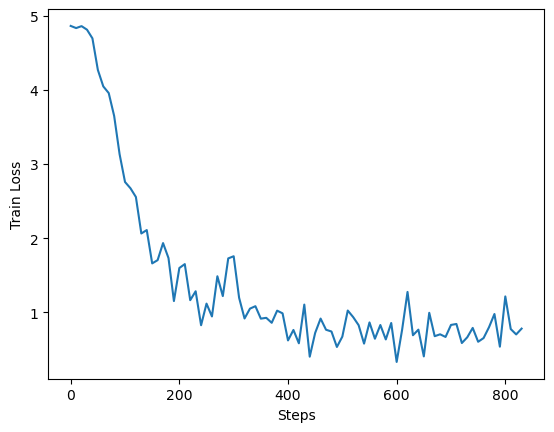

<Figure size 640x480 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
from smdebug.trials import create_trial
path = estimator.latest_job_debugger_artifacts_path()
create_trial(path)

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()
plt.savefig('trainloss.png')

In [50]:
! aws s3 ls {rule_output_path} --recursive


Parameter validation failed:
Invalid bucket name "{rule_output_path}": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:(s3|s3-object-lambda):[a-z\-0-9]*:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-.]{1,63}$|^arn:(aws).*:s3-outposts:[a-z\-0-9]+:[0-9]{12}:outpost[/:][a-zA-Z0-9\-]{1,63}[/:]accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


In [51]:
! aws s3 cp {rule_output_path} ./ --recursive


usage: aws s3 cp <LocalPath> <S3Uri> or <S3Uri> <LocalPath> or <S3Uri> <S3Uri>
Error: Invalid argument type


In [56]:
import os
profiler_report_name = [ rule["RuleConfigurationName"]
                        for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                        ][0]

In [57]:
profiler_report_name

'ProfilerReport'

In [2]:
#import IPython
#IPython.display.HTML(filename= profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [59]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/output/model.tar.gz'

In [60]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-283573335284/pytorch-training-2024-03-04-21-11-55-516/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-283573335284/pytorch-inference-2024-03-04-22-23-24-129/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-03-04-22-23-32-960
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-03-04-22-23-33-653
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-03-04-22-23-33-653


-----!

In [61]:
from PIL import Image
import io
import os
import numpy as np

test_image = "./dogImages/test/016.Beagle/Beagle_01130.jpg"

with open(test_image , "rb") as f:
    payload = f.read()
    print("Expected Breed Class is 16")
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
    predict = np.argmax(response, 1) + 1
    print(f"Predicted Breed Class is {predict}")

Expected Breed Class is 16
Predicted Breed Class is [16]


In [62]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-03-04-22-23-33-653
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-03-04-22-23-33-653
